In [3]:
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt


In [56]:
tickers = ['VTI', 'AGG', 'DBC', '^VIX']
data = yf.download(tickers, start="2006-01-01", end="2020-12-31", interval="1d")['Adj Close']
data_na = data.dropna(axis=0).copy() 

for column in data_na.columns:
    data_na.loc[:, f'{column}_r(t)'] = data_na[column].pct_change()
    data_na.loc[:, f'{column}_r(t+1)'] = data_na[f'{column}_r(t)'].shift(-1)

data_na.dropna(axis=0, inplace=True)
data_na.reset_index(inplace=True)
data_na['Date'] = data_na['Date'].dt.date

data_na


[*********************100%***********************]  4 of 4 completed


Ticker,Date,AGG,DBC,VTI,^VIX,AGG_r(t),AGG_r(t+1),DBC_r(t),DBC_r(t+1),VTI_r(t),VTI_r(t+1),^VIX_r(t),^VIX_r(t+1)
0,2006-02-07,56.438583,20.285254,44.219494,13.590000,-0.000698,-0.000500,-0.028926,-0.004255,-0.009736,0.007194,0.042178,-0.055923
1,2006-02-08,56.410374,20.198933,44.537613,12.830000,-0.000500,0.000600,-0.004255,0.009402,0.007194,-0.001904,-0.055923,0.022603
2,2006-02-09,56.444237,20.388838,44.452793,13.120000,0.000600,-0.002098,0.009402,-0.018205,-0.001904,0.002067,0.022603,-0.019055
3,2006-02-10,56.325829,20.017662,44.544697,12.870000,-0.002098,0.000701,-0.018205,-0.015524,0.002067,-0.004523,-0.019055,0.037296
4,2006-02-13,56.365299,19.706909,44.343201,13.350000,0.000701,-0.001600,-0.015524,-0.008322,-0.004523,0.009486,0.037296,-0.082397
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3745,2020-12-22,106.759193,13.624199,181.857010,24.230000,0.001443,-0.000678,-0.011004,0.012517,0.000207,0.001710,-0.036963,-0.037969
3746,2020-12-23,106.686806,13.794738,182.168045,23.309999,-0.000678,0.000933,0.012517,0.002747,0.001710,0.001673,-0.037969,-0.076362
3747,2020-12-24,106.786354,13.832635,182.472778,21.530001,0.000933,0.000169,0.002747,-0.006164,0.001673,0.006327,-0.076362,0.007896
3748,2020-12-28,106.804443,13.747366,183.627335,21.700001,0.000169,0.000170,-0.006164,0.002757,0.006327,-0.004174,0.007896,0.063594


In [57]:
def rebalance_portfolio(row, prev_alloc, prices, initial_allocation):
    total_value = (prev_alloc * prices).sum()  # Calcul de la valeur totale du portefeuille
    new_alloc = [(total_value * alloc) / price for alloc, price in zip(initial_allocation, prices)]
    return pd.Series(new_alloc)


In [ ]:
import pandas as pd

def compute_weights(model, alloc_step, period, dataframe, initial_allocation=None):
    if model == "Reallocation":
        # Conversion du tuple en objets datetime
        start_date, end_date = pd.to_datetime(period[0]), pd.to_datetime(period[1])

        # Assurer que la colonne Date est en Timestamp
        dataframe['Date'] = pd.to_datetime(dataframe['Date'])

        # Filtrage du DataFrame selon les dates
        data = dataframe[(dataframe['Date'] >= start_date) & (dataframe['Date'] <= end_date)]

        # Extraction des colonnes d'actifs
        df_actifs = data[["Date", "AGG", "DBC", "VTI", "^VIX"]]
        portfolio_value = 1

        # Créer un DataFrame pour les allocations initiales
        allocation_df = pd.DataFrame(index=data.index, columns=[f'{col}_alloc' for col in df_actifs.columns[1:]])

        # Initialiser les allocations du portefeuille pour chaque actif
        initial_prices = data.iloc[0, 1:]  # Prix initiaux des actifs
        allocation_df.iloc[0] = [portfolio_value * alloc / price for alloc, price in zip(initial_allocation, initial_prices)]

        # Initialiser le DataFrame pour la valeur du portefeuille
        portfolio_df = pd.DataFrame(index=data.index, columns=['portfolio_value'])
        portfolio_df.iloc[0] = portfolio_value

        # Parcourir chaque date et réallouer le portefeuille selon la période définie
        for i in range(1, len(data)):
            current_date = pd.to_datetime(data.loc[i, 'Date'])
            previous_date = pd.to_datetime(data.loc[i - 1, 'Date'])
            
            # Vérifier le changement de période pour la réallocation
            if (alloc_step == 'year' and current_date.year != previous_date.year) or \
               (alloc_step == 'month' and (current_date.year != previous_date.year or current_date.month != previous_date.month)) or \
               (alloc_step == 'day' and current_date != previous_date):
                
                previous_alloc = allocation_df.iloc[i - 1].values.astype(float)
                current_prices = data.iloc[i, 1:].values.astype(float)
                
                # Réallocation basée sur les prix actuels et les allocations initiales
                allocation_df.iloc[i] = rebalance_portfolio(data.iloc[i], previous_alloc, current_prices, initial_allocation)
            
            else:
                # Conserver la même allocation
                allocation_df.iloc[i] = allocation_df.iloc[i - 1]
            
            # Mise à jour de la valeur du portefeuille
            portfolio_df.loc[i, 'portfolio_value'] = (allocation_df.iloc[i] * data.iloc[i, 1:].values).sum()

        # Déterminer la première année de la période
        first_date = pd.to_datetime(data['Date'].iloc[0])
        first_year = first_date.year

        # Initialisation du DataFrame des poids
        weights_df = pd.DataFrame(index=data.index, columns=data.columns[1:])

        # Poids fixes pour la première année
        weights_first_year = initial_allocation  

        # Assignation des poids pour la première année et les années suivantes
        for i in range(len(data)):
            current_year = pd.to_datetime(data.loc[i, 'Date']).year
            
            if current_year == first_year:
                weights_df.loc[i] = weights_first_year  
            elif current_year > first_year:
                # Si c'est la première occurrence de l'année
                if i == 0 or pd.to_datetime(data.loc[i - 1, 'Date']).year != current_year:
                    # Récupérer les prix de la première ligne de l'année
                    first_row_prices = data.iloc[i, 1:].values.astype(float)
                    # Calculer les poids basés sur la première ligne de l'année
                    weights_df.loc[i] = fixed_weights = first_row_prices / first_row_prices.sum()
                else:
                    # Pour les autres jours de la même année, conserver les mêmes poids
                    weights_df.loc[i] = weights_df.loc[i - 1]

    return weights_df



In [ ]:
period = ("2011-01-01", "2020-04-30")
model = "Reallocation"
alloc_step = "year"
initial_allocation = [0.25, 0.25, 0.25, 0.25]

weights_realloc = compute_weights(model, alloc_step, period, data_na, initial_allocation)


In [ ]:
weights_realloc

#######

In [58]:
# Allocation initiale
initial_allocation = [0.25, 0.25, 0.25, 0.25]  # Allocations initiales pour VTI, AGG, DBC, VIX
portfolio_value = 1
test = data_na[["Date", "AGG", "DBC", "VTI", "^VIX"]]

In [59]:
# Créer un DataFrame pour les allocations initiales
allocation_df = pd.DataFrame(index=data_na.index, columns=[f'{col}_alloc' for col in test.columns[1:]])

# Initialiser les allocations du portefeuille pour chaque actif
initial_prices = data_na.iloc[0, 1:]  # Prix initiaux des actifs
allocation_df.iloc[0] = [portfolio_value * alloc / price for alloc, price in zip(initial_allocation, initial_prices)]


In [60]:
# DataFrame pour stocker les valeurs du portefeuille
portfolio_df = pd.DataFrame(index=data_na.index, columns=['Date', 'portfolio_value'])
portfolio_df['Date'] = data_na['Date']

In [104]:
# Paramètre de période de réallocation : 'day', 'month', ou 'year'
rebalancing_period = 'day'  # Change à 'day', 'month', ou 'year' selon la fréquence souhaitée


In [105]:
# Parcourir chaque date et réallouer le portefeuille selon la période définie
for i in range(1, len(test)):
    current_date = pd.to_datetime(test.loc[i, 'Date'])
    previous_date = pd.to_datetime(test.loc[i - 1, 'Date'])
    
    # Vérifier le changement de période pour la réallocation
    if (rebalancing_period == 'year' and current_date.year != previous_date.year) or \
       (rebalancing_period == 'month' and (current_date.year != previous_date.year or current_date.month != previous_date.month)) or \
       (rebalancing_period == 'day' and current_date != previous_date):
        
        previous_alloc = allocation_df.iloc[i - 1].values.astype(float)
        current_prices = test.iloc[i, 1:].values.astype(float)
        
        # Réallocation basée sur les prix actuels et les allocations initiales
        allocation_df.iloc[i] = rebalance_portfolio(test.iloc[i], previous_alloc, current_prices, initial_allocation)
        
        # Mettre à jour les poids basés sur la nouvelle allocation
        weights_df.loc[i] = allocation_df.iloc[i] / allocation_df.iloc[i].sum()
        
    else:
        # Conserver la même allocation et poids
        allocation_df.iloc[i] = allocation_df.iloc[i - 1]
        weights_df.loc[i] = weights_df.loc[i - 1]
    
    # Mise à jour de la valeur du portefeuille
    portfolio_df.loc[i, 'portfolio_value'] = (allocation_df.iloc[i] * test.iloc[i, 1:].values).sum() 



/tmp/ipykernel_162236/2569649427.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weights_df.loc[i] = allocation_df.iloc[i] / allocation_df.iloc[i].sum()


In [106]:
# Déterminer la première année de la période
first_date = pd.to_datetime(test['Date'].iloc[0])
first_year = first_date.year

# Initialisation du DataFrame des poids
weights_df = pd.DataFrame(index=test.index, columns=test.columns[1:])

# Poids fixes pour la première année
weights_first_year = initial_allocation  

# Assignation des poids pour la première année et les années suivantes
for i in range(len(test)):
    current_year = pd.to_datetime(test.loc[i, 'Date']).year
    
    if current_year == first_year:
        weights_df.loc[i] = weights_first_year  
    elif current_year > first_year:
        # Si c'est la première occurrence de l'année
        if i == 0 or pd.to_datetime(test.loc[i - 1, 'Date']).year != current_year:
            # Récupérer les prix de la première ligne de l'année
            first_row_prices = test.iloc[i, 1:].values.astype(float)
            # Calculer les poids basés sur la première ligne de l'année
            weights_df.loc[i] = fixed_weights = first_row_prices / first_row_prices.sum()
        else:
            # Pour les autres jours de la même année, conserver les mêmes poids
            weights_df.loc[i] = weights_df.loc[i - 1]


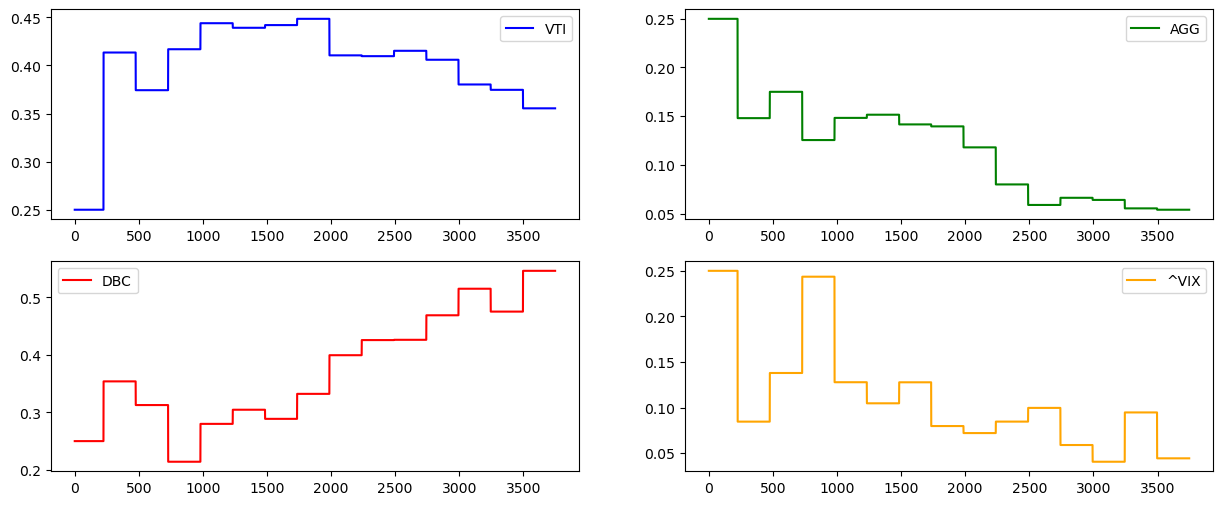

In [130]:
fig, axs = plt.subplots(2,2, figsize=(15, 6))
colors = ['blue', 'green', 'red', 'orange']
axs = axs.flatten()
for i in range(len(axs)):
    axs[i].plot(weights_df.iloc[:,i].values, label=tickers[i], color=colors[i])
    axs[i].legend()


In [109]:
# Calculer les rendements quotidiens
returns_df = data_na[["AGG_r(t+1)", "DBC_r(t+1)", "VTI_r(t+1)", "^VIX_r(t+1)"]]

In [110]:
# Calculer le produit terme à terme
weighted_returns = returns_df.values * weights_df.values

# Somme sur les lignes pour obtenir le rendement du portefeuille
portfolio_returns = weighted_returns.sum(axis=1)

In [128]:
portfolio_returns

2      -0.115092
3      -0.021269
4      -0.065898
5        0.00508
6        0.01327
          ...   
3745    0.001002
3746    0.025514
3747    0.038485
3748   -0.015573
3749    0.032666
Length: 3748, dtype: object

In [132]:
# Calcul de l'espérance des rendements (moyenne)
expected_return = portfolio_returns.mean()
expected_return = (expected_return+1)**252-1

# Calcul de la standard déviation
std_dev = portfolio_returns.std()
std_dev = std_dev * np.sqrt(252)
risk_free_rate = 0.0

# Calcul du Sharpe ratio
sharpe_ratio = (expected_return - risk_free_rate) / std_dev

# Affichage des résultats
print(f"Espérance des rendements : {expected_return:.4f}")
print(f"Standard déviation : {std_dev:.4f}")
print(f"Sharpe ratio : {sharpe_ratio:.4f}")


Espérance des rendements : 2.5250
Standard déviation : 0.8276
Sharpe ratio : 3.0509


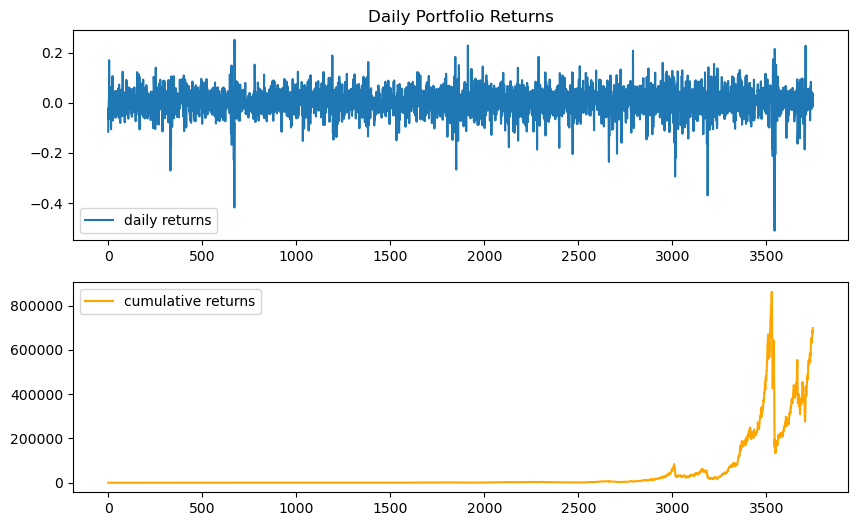

In [127]:
portfolio_alloc_returns = pd.DataFrame(portfolio_returns, columns=["portfolio_alloc_returns"])

# Calculate cumulative returns
portfolio_alloc_returns["cumulative_rets"] = (1 + portfolio_alloc_returns["portfolio_alloc_returns"]).cumprod() - 1


fig, axs = plt.subplots(2, 1, figsize=(10, 6))

# Plot daily returns
axs[0].plot(portfolio_alloc_returns["portfolio_alloc_returns"].values, label="daily returns")
axs[0].legend()
axs[0].set_title("Daily Portfolio Returns")

# Plot cumulative returns
axs[1].plot(portfolio_alloc_returns["cumulative_rets"].values, label="cumulative returns", color='orange')
axs[1].legend()


## Prise en compte du cout de transaction

In [113]:
C = 0.0005 

# Initialisation du vecteur des coûts de transaction
transaction_costs = np.zeros(len(weights_df))

# Calcul des coûts de transaction
for t in range(2, len(weights_df)):
    # Calcul des différences de poids
    diff_weights = weights_df.iloc[t - 1].values - weights_df.iloc[t - 2].values
    
    # Somme des valeurs absolues des différences
    sum_abs_diff = np.sum(np.abs(diff_weights))
    
    # Coût de transaction pour le temps t
    transaction_costs[t] = C * sum_abs_diff


In [114]:
portfolio_with_transac_cost = portfolio_returns - transaction_costs

In [115]:
# Calcul de l'espérance des rendements (moyenne)
expected_return = portfolio_with_transac_cost.mean()
expected_return = (expected_return+1)**252-1

# Calcul de la standard déviation
std_dev = portfolio_with_transac_cost.std()
std_dev = std_dev * np.sqrt(252)
risk_free_rate = 0.0

# Calcul du Sharpe ratio
sharpe_ratio = (expected_return - risk_free_rate) / std_dev

# Affichage des résultats
print(f"Espérance des rendements : {expected_return:.4f}")
print(f"Standard déviation : {std_dev:.4f}")
print(f"Sharpe ratio : {sharpe_ratio:.4f}")


Espérance des rendements : 0.1318
Standard déviation : 0.1108
Sharpe ratio : 1.1902


## Prise en compte de la volatilité scaling

In [116]:
# Initialisation du DataFrame pour stocker les volatilités ex-ante
volatility_df = pd.DataFrame(index=returns_df.index, columns=returns_df.columns)

# Boucle sur chaque colonne (actif) pour calculer la volatilité
for col in returns_df.columns:
    # Calcul de la variance exponentiellement pondérée sur 50 jours
    ew_var = returns_df[col].ewm(span=50, adjust=False).var()
    
    # Calcul de la volatilité ex-ante en prenant la racine carrée de la variance
    volatility_df[col] = ew_var.shift(1).apply(lambda x: x**0.5)



In [117]:
volatility_df.iloc[48:53]

Ticker,AGG_r(t+1),DBC_r(t+1),VTI_r(t+1),^VIX_r(t+1)
48,0.002038,0.010677,0.006194,0.044652
49,0.002011,0.010556,0.006070,0.043731
50,0.001985,0.010719,0.005946,0.043484
51,0.001945,0.011147,0.005841,0.042597
52,0.002068,0.011813,0.005795,0.041947


In [118]:
# Définition du paramètre alpha
vol_target = 0.1 

vol_scale_df = vol_target / volatility_df


In [119]:
# Suppression des deux premières lignes de vol_scale_df
vol_scale_df = vol_scale_df.iloc[2:]

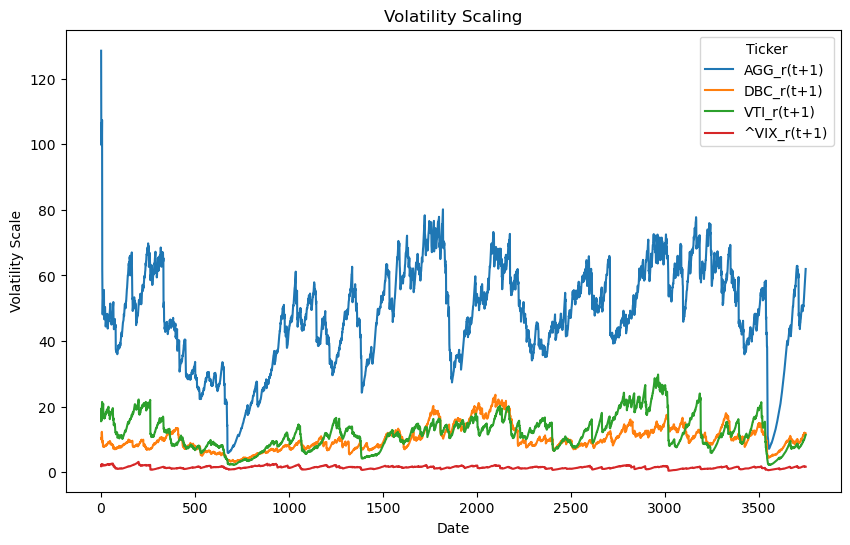

In [120]:
# Création du graphique
vol_scale_df.plot(figsize=(10, 6))
plt.title("Volatility Scaling")
plt.xlabel("Date")
plt.ylabel("Volatility Scale")
plt.show()

In [121]:
returns_df = returns_df.iloc[2:]
weights_df = weights_df.iloc[2:]

In [122]:
# Calculer le produit terme à terme
weighted_returns = vol_scale_df * returns_df.values * weights_df.values 

In [123]:
# Somme sur les lignes pour obtenir le rendement du portefeuille
portfolio_returns = weighted_returns.sum(axis=1)


In [124]:
# Initialisation du vecteur des coûts de transaction
transaction_costs = np.zeros(len(weights_df))

# Calcul des coûts de transaction
for t in range(2, len(weights_df)):
    # Calcul des différences de poids
    diff_weights = vol_scale_df.iloc[t - 1].values*weights_df.iloc[t - 1].values - vol_scale_df.iloc[t - 2].values*weights_df.iloc[t - 2].values
    
    # Somme des valeurs absolues des différences
    sum_abs_diff = np.sum(np.abs(diff_weights))
    
    # Coût de transaction pour le temps t
    transaction_costs[t] = C * sum_abs_diff



In [125]:
portfolio_with_transac_cost = portfolio_returns - transaction_costs

In [126]:
# Calcul de l'espérance des rendements (moyenne)
expected_return = portfolio_with_transac_cost.mean()
expected_return = (expected_return+1)**252-1

# Calcul de la standard déviation
std_dev = portfolio_with_transac_cost.std()
std_dev = std_dev * np.sqrt(252)
risk_free_rate = 0.0

# Calcul du Sharpe ratio
sharpe_ratio = (expected_return - risk_free_rate) / std_dev

# Affichage des résultats
print(f"Espérance des rendements : {expected_return:.4f}")
print(f"Standard déviation : {std_dev:.4f}")
print(f"Sharpe ratio : {sharpe_ratio:.4f}")


Espérance des rendements : 2.3032
Standard déviation : 0.8278
Sharpe ratio : 2.7823
